# 1.) Data preprocessing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date
from pprint import pprint

In [2]:
#Ceilometer data
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

#CTM model data
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
#WRF model data

data_path = "C:/Users/vichu/Downloads/90106"

wrf_data_path = "//WRF_PBLH"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)



In [4]:
#Converting UTC to AEST

def convert_df_to_datetime_wrf(df):
    df['time_AEST'] = (df['time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,'date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[5:7]
        day_date_1 = int(date_1[8::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    df = df[~df.index.duplicated(keep = 'first')]
    
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H')
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [5]:
wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [6]:
#Combining WRF with CL and CTM model data

import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

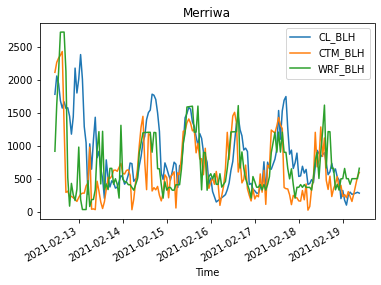

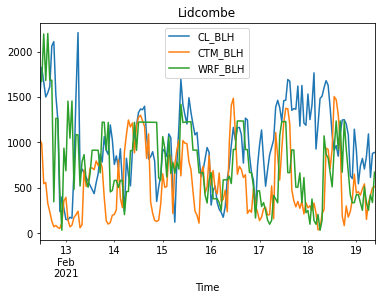

In [7]:
#Plots of Lidcombe and Merriwa BL heights
bl_plot('Merriwa', wrf_df_merriwa)
bl_plot('Lidcombe', wrf_df_lidcombe)

### 1.1 Scraping of air quality data

In [8]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [9]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [10]:

df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]

In [11]:
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [12]:
#Consolidating all the data in a dict
data = {site: bl_external(site, id) for site, id in sites.items()}

# 2.) Correlation analysis and statistical metrics

### 2.1 Correlation analysis

In [13]:
#Calculating correlation and p-values for the features w.r.t the BL height

def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [14]:
#Correlation and p values for Lidcombe and Merriwa

'''
corr('all', 'pearson').iloc[:, :3]
p_value('all').iloc[:, :3]
corr('Lidcombe', 'pearson').iloc[:, :3]
p_value('Lidcombe').iloc[:, :3]
corr('Merriwa', 'pearson').iloc[:, :3]
p_value('Merriwa').iloc[:, :3]
'''

"\ncorr('all', 'pearson').iloc[:, :3]\np_value('all').iloc[:, :3]\ncorr('Lidcombe', 'pearson').iloc[:, :3]\np_value('Lidcombe').iloc[:, :3]\ncorr('Merriwa', 'pearson').iloc[:, :3]\np_value('Merriwa').iloc[:, :3]\n"

### 2.2 Statistical metrics

In [15]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#checking everything in place

In [16]:
#Interpolating missing values by time
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [17]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [18]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):
    
    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    for i in range(d):
        col_name = 'temp'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
  
    for i in range(d):
        col_name = 'CL_BLH_diff' + str(i+1)
        target_col = 'temp'+str(i+1)
        df_func[col_name] = df_func[target_col].shift(1)
        
    for i in range(d-1):
        col_name = 'CL_BLH_roll_mean' + str(i+1)
        df_func[col_name] = df_func['CL_BLH'].rolling(i+2).mean().shift(1)
    
    
    to_drop_list = ['temp1','temp2','temp3','temp4','temp5']
        
    df_func = df_func.drop(to_drop_list, axis = 1)
        
    return df_func

In [19]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [20]:
df_merriwa_wlags

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,...,CL_BLH_lag5,CL_BLH_diff1,CL_BLH_diff2,CL_BLH_diff3,CL_BLH_diff4,CL_BLH_diff5,CL_BLH_roll_mean1,CL_BLH_roll_mean2,CL_BLH_roll_mean3,CL_BLH_roll_mean4
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,...,NaN,277.932557,NaN,NaN,NaN,NaN,1921.937977,NaN,NaN,NaN
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,...,NaN,-118.009518,159.923039,NaN,NaN,NaN,2001.899496,1928.923563,NaN,NaN
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,...,NaN,-258.163554,-376.173073,-98.240515,NaN,NaN,1813.812960,1896.176725,1867.875468,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-02-19,5,264.802803,156.5146,501.85,-0.033830,91.658,0.102,-0.022306,0.170322,...,322.490067,46.731527,197.027280,122.500602,-24.570602,98.876668,274.553701,216.666529,206.354613,229.581704
162,2021-02-19,6,271.336676,271.2063,501.62,-0.035252,91.979,0.105,-0.011042,0.139426,...,175.418863,-33.116662,13.614865,163.910618,89.383939,-57.687264,281.361134,271.303402,228.700598,218.044251
163,2021-02-19,7,283.446311,402.5884,502.13,-0.032138,92.351,0.099,0.039190,0.266695,...,100.892185,6.533873,-26.582789,20.148738,170.444491,95.917813,268.069739,278.019648,271.311720,237.227813
164,2021-02-19,8,295.176486,530.2465,503.18,-0.027304,92.986,0.131,0.079679,0.325995,...,251.187938,12.109635,18.643508,-14.473154,32.258373,182.554126,277.391494,273.195263,279.376314,273.738639


In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [22]:
#From: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

#Index of agreement(model prediction error)


def index_agreement(s, o):
    """
    Willmott index of agreement

    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [23]:
#mean bias error

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

In [24]:
def MASE(training_series, testing_series, prediction_series):

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [25]:
#DTW distance(Dynamic Time Warping)
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [26]:
#Function to calculate and print out metrics

def statistical_metrics_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMASE:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [27]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
MASE:0.90875


In [28]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:8749.96
MASE:2.29637


In [29]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.64988
Root mean squared error:333.80451
Mean absoluate error:274.93361
Mean bias error:180.78693
DTW distance:5847.39
MASE:1.45449


In [30]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.53857
Root mean squared error:458.91711
Mean absoluate error:384.71552
Mean bias error:-343.37658
DTW distance:7725.26
MASE:1.74913


# 3.) Regression models

### 3.1.1 Train test split and consideration of all features

In [31]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

In [32]:
#list of all features 
feature_list_all

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [33]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()
feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

#Feature list with lags and BL difference

feature_list_all_ld = feature_list_all_wlags.copy()
feature_list_all_ld.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

#Feature list with lags, difference and rolling mean
feature_list_all_ldm = feature_list_all_ld.copy()
feature_list_all_ldm.extend(['CL_BLH_roll_mean1', 'CL_BLH_roll_mean2', 'CL_BLH_roll_mean3', 'CL_BLH_roll_mean4'])

feature_list_all_ldm

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5',
 'CL_BLH_diff1',
 'CL_BLH_diff2',
 'CL_BLH_diff3',
 'CL_BLH_diff4',
 'CL_BLH_diff5',
 'CL_BLH_roll_mean1',
 'CL_BLH_roll_mean2',
 'CL_BLH_roll_mean3',
 'CL_BLH_roll_mean4']

### 3.1.2 Plots

In [34]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']
    z = df['WRF_BLH']
    # Plot the residuals after fitting a linear model
    #sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    #df.plot(title = pred_plot_title, figsize=(15,10))
    #df.plot(x=x, y=z, color ="r").set(title = pred_plot_title)

### 3.1.3 Statistical metrics result

In [35]:
def results_print(df, train_series, title):
    #pred_plots(df, title)
    statistical_metrics_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

In [36]:
train = df_merriwa_wlags.head(142).dropna()
test = df_merriwa_wlags.tail(24)

X_train = train[feature_list_all_ldm]
X_test = test[feature_list_all_ldm]

y_train = train['CL_BLH']
y_test = test['CL_BLH']

# Random forest hyper

## Random search

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [40]:
print(rf_random.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [120]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_split=5,
                      n_estimators=200)

## GridsearchCV

In [122]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [400, 600, 800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [123]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [70, 80, 90],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [400, 600, 800]},
             verbose=2)

In [124]:
# Fit the grid search to the data
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [125]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=400)

## Evaluation

In [45]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy



In [46]:
base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 145.2753 degrees.
Accuracy = 45.56%.


Model Performance
Average Error: 144.5249 degrees.
Accuracy = 48.84%.


Improvement of 7.21%.


In [47]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 147.1320 degrees.
Accuracy = 46.91%.


Improvement of 2.96%.


#  SVR hyper 

## Random search

In [48]:
from sklearn import svm

In [49]:
vreg = svm.LinearSVR()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(vreg.get_params())

Parameters currently in use:

{'C': 1.0,
 'dual': True,
 'epsilon': 0.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}


In [50]:
parameters = { 'C':[1.5, 10],'epsilon':[0.1,0.2,0.5,0.3],'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'], 'fit_intercept':[True, False]}

In [51]:
svr_random = RandomizedSearchCV(estimator = vreg, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
svr_random.fit(X_train, y_train)

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.5s finished
C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, estimator=LinearSVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1.5, 10],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'fit_intercept': [True, False],
                                        'loss': ['epsilon_insensitive',
                                                 'squared_epsilon_insensitive']},
                   verbose=2)

In [52]:
svr_random.best_params_

{'loss': 'squared_epsilon_insensitive',
 'fit_intercept': False,
 'epsilon': 0.3,
 'C': 10}

In [53]:
svr_random.best_estimator_

LinearSVR(C=10, epsilon=0.3, fit_intercept=False,
          loss='squared_epsilon_insensitive')

## Grid search

In [54]:
grid_svr = GridSearchCV(estimator = vreg, param_grid = parameters, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.5s finished
C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
             param_grid={'C': [1.5, 10], 'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'fit_intercept': [True, False],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             verbose=2)

In [55]:
grid_svr.best_params_

{'C': 1.5,
 'epsilon': 0.1,
 'fit_intercept': False,
 'loss': 'epsilon_insensitive'}

In [56]:
grid_svr.best_estimator_

LinearSVR(C=1.5, epsilon=0.1, fit_intercept=False)

## Evaluation

In [57]:
base_model = svm.LinearSVR()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = svr_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 223.2595 degrees.
Accuracy = 37.10%.


Model Performance
Average Error: 140.5820 degrees.
Accuracy = 58.48%.


Improvement of 57.62%.


C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [58]:
best_grid = grid_svr.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 128.1960 degrees.
Accuracy = 64.01%.


Improvement of 72.51%.


# MLR hyper

In [59]:
from sklearn.linear_model import LinearRegression

## Random search

In [60]:
mlr = LinearRegression()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(mlr.get_params())

Parameters currently in use:

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [61]:
parameters = { 'copy_X':[True, False], 'fit_intercept':[True, False], 'n_jobs':[1, 2, 3, 4, 5, 6, 7, 8, None], 'normalize':[True, False]}

In [62]:
mlr_random = RandomizedSearchCV(estimator = mlr, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
mlr_random.fit(X_train, y_train)

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, estimator=LinearRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8,
                                                   None],
                                        'normalize': [True, False]},
                   verbose=2)

In [63]:
mlr_random.best_params_

{'normalize': True, 'n_jobs': 1, 'fit_intercept': False, 'copy_X': True}

In [64]:
mlr_random.best_estimator_

LinearRegression(fit_intercept=False, n_jobs=1, normalize=True)

## Grid search

In [65]:
# Instantiate the grid search model
grid_mlr = GridSearchCV(estimator = mlr, param_grid = parameters, verbose = 2,n_jobs = -1)
grid_mlr.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished


GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, None],
                         'normalize': [True, False]},
             verbose=2)

In [66]:
grid_mlr.best_params_

{'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'normalize': True}

In [67]:
grid_mlr.best_estimator_

LinearRegression(fit_intercept=False, n_jobs=1, normalize=True)

## Evaluation

In [68]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = mlr_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 144.9949 degrees.
Accuracy = 44.39%.


Model Performance
Average Error: 139.6585 degrees.
Accuracy = 47.90%.


Improvement of 7.92%.


In [69]:
best_grid = grid_mlr.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 139.6585 degrees.
Accuracy = 47.90%.


Improvement of 7.92%.


# Decision tree hyper 

In [71]:
from sklearn.tree import DecisionTreeRegressor

## Random Search

In [72]:
tree = DecisionTreeRegressor()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(tree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [73]:
parameters = {'criterion':['mse', 'friedman_mse', 'poisson'], 'max_depth':[2, 3, None], 'max_features':['auto', 'sqrt', 'log2'], 'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, None]}

In [74]:
tree_random = RandomizedSearchCV(estimator = tree, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
tree_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [2, 3, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, None]},
                   verbose=2)

In [75]:
tree_random.best_params_

{'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'mse'}

In [76]:
tree_random.best_estimator_

DecisionTreeRegressor(max_features='log2', min_samples_leaf=6)

## Grid search

In [77]:
# Instantiate the grid search model
grid_tree = GridSearchCV(estimator = tree, param_grid = parameters, verbose = 2,n_jobs = -1)
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1306 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    1.7s finished


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'poisson'],
                         'max_depth': [2, 3, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]},
             verbose=2)

In [79]:
grid_tree.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 9}

In [80]:
grid_tree.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='sqrt', min_samples_leaf=9)

## Evaluation

In [81]:
base_model = DecisionTreeRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = tree_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 210.2628 degrees.
Accuracy = 15.92%.


Model Performance
Average Error: 149.6972 degrees.
Accuracy = 60.39%.


Improvement of 279.44%.


In [82]:
best_grid = grid_tree.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 212.4541 degrees.
Accuracy = 32.38%.


Improvement of 103.48%.


## 3.5 Lasso regression 

In [83]:
from sklearn.linear_model import Lasso

## Random search

In [84]:
lso = Lasso()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(lso.get_params())

Parameters currently in use:

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [87]:
parameters = {'alpha':[1, 1.5, 2, 5], 'copy_X':[True, False], 'fit_intercept':[True, False], 
             'max_iter':[1000, 1200, 1400, 1600], 'normalize':[True, False], 'selection':['cyclic', 'random'],
             'tol':[1e-3, 1e-4, 1e-5, 1e-6]}

In [89]:
lasso_random = RandomizedSearchCV(estimator = lso, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
lasso_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished


RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 1.5, 2, 5],
                                        'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'max_iter': [1000, 1200, 1400, 1600],
                                        'normalize': [True, False],
                                        'selection': ['cyclic', 'random'],
                                        'tol': [0.001, 0.0001, 1e-05, 1e-06]},
                   verbose=2)

In [90]:
lasso_random.best_params_

{'tol': 1e-06,
 'selection': 'random',
 'normalize': True,
 'max_iter': 1600,
 'fit_intercept': True,
 'copy_X': True,
 'alpha': 2}

In [91]:
lasso_random.best_estimator_

Lasso(alpha=2, max_iter=1600, normalize=True, selection='random', tol=1e-06)

## Grid search

In [92]:
# Instantiate the grid search model
grid_lasso = GridSearchCV(estimator = lso, param_grid = parameters, verbose = 2,n_jobs = -1)
grid_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 4800 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:   12.2s finished


GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1, 1.5, 2, 5], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 1200, 1400, 1600],
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             verbose=2)

In [93]:
grid_lasso.best_params_

{'alpha': 2,
 'copy_X': False,
 'fit_intercept': True,
 'max_iter': 1200,
 'normalize': True,
 'selection': 'random',
 'tol': 0.001}

In [94]:
grid_lasso.best_estimator_

Lasso(alpha=2, copy_X=False, max_iter=1200, normalize=True, selection='random',
      tol=0.001)

## Evaluation

In [95]:
base_model = Lasso()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = lasso_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1719724.8293 degrees.
Accuracy = -357721.59%.


Model Performance
Average Error: 146.6306 degrees.
Accuracy = 50.08%.


Improvement of -100.01%.


In [96]:
best_grid = grid_lasso.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 147.1240 degrees.
Accuracy = 50.02%.


Improvement of -100.01%.


# Ridge regression hyper

In [98]:
from sklearn.linear_model import Ridge

## Random search

In [99]:
rid = Ridge()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rid.get_params())

Parameters currently in use:

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


In [100]:
parameters = {'alpha':[1, 1.5, 2, 5], 'copy_X':[True, False], 'fit_intercept':[True, False], 
             'max_iter':[1000, 1200, 1400, 1600], 'normalize':[True, False], 'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga', 'sparse_cg'],
             'tol':[1e-3, 1e-4, 1e-5, 1e-6]}

In [101]:
ridge_random = RandomizedSearchCV(estimator = rid, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
ridge_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.1s finished


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 1.5, 2, 5],
                                        'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'max_iter': [1000, 1200, 1400, 1600],
                                        'normalize': [True, False],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sag', 'saga',
                                                   'sparse_cg'],
                                        'tol': [0.001, 0.0001, 1e-05, 1e-06]},
                   verbose=2)

In [102]:
ridge_random.best_params_

{'tol': 0.001,
 'solver': 'sag',
 'normalize': False,
 'max_iter': 1200,
 'fit_intercept': True,
 'copy_X': False,
 'alpha': 1}

In [103]:
ridge_random.best_estimator_

Ridge(alpha=1, copy_X=False, max_iter=1200, solver='sag')

## Grid search

In [104]:
# Instantiate the grid search model
grid_ridge = GridSearchCV(estimator = rid, param_grid = parameters, verbose = 2,n_jobs = -1)
grid_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 3584 candidates, totalling 17920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4800 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 9328 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 15168 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 17920 out of 17920 | elapsed:   30.3s finished


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1, 1.5, 2, 5], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 1200, 1400, 1600],
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag',
                                    'saga', 'sparse_cg'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             verbose=2)

In [105]:
grid_ridge.best_params_

{'alpha': 1,
 'copy_X': False,
 'fit_intercept': True,
 'max_iter': 1400,
 'normalize': False,
 'solver': 'saga',
 'tol': 0.001}

In [106]:
grid_ridge.best_estimator_

Ridge(alpha=1, copy_X=False, max_iter=1400, solver='saga')

## Evaluation

In [107]:
base_model = Ridge()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = ridge_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1598700.9449 degrees.
Accuracy = -333590.21%.


Model Performance
Average Error: 1598627.9826 degrees.
Accuracy = -333571.50%.


Improvement of -0.01%.


In [108]:
best_grid = grid_ridge.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1599022.0556 degrees.
Accuracy = -333672.91%.


Improvement of 0.02%.


# Elastic Net hyper

In [109]:
from sklearn.linear_model import ElasticNet

## Random search

In [110]:
enet = ElasticNet()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(enet.get_params())

Parameters currently in use:

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [111]:
parameters = {'alpha':[1, 1.5, 2, 5, 10], 'copy_X':[True, False], 'fit_intercept':[True, False], 
             'max_iter':[1000, 1200, 1400, 1600, 1800], 'normalize':[True, False], 'l1_ratio':[0, 0.25, 0.5, 0.75, 1],
             'tol':[1e-3, 1e-4, 1e-5, 1e-6], 'selection':['cyclic', 'random']}

In [112]:
enet_random = RandomizedSearchCV(estimator = enet, param_distributions = parameters, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
enet_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.8s finished


RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 1.5, 2, 5, 10],
                                        'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                                        'max_iter': [1000, 1200, 1400, 1600,
                                                     1800],
                                        'normalize': [True, False],
                                        'selection': ['cyclic', 'random'],
                                        'tol': [0.001, 0.0001, 1e-05, 1e-06]},
                   verbose=2)

In [113]:
enet_random.best_params_

{'tol': 1e-05,
 'selection': 'random',
 'normalize': False,
 'max_iter': 1800,
 'l1_ratio': 1,
 'fit_intercept': True,
 'copy_X': True,
 'alpha': 2}

In [114]:
enet_random.best_estimator_

ElasticNet(alpha=2, l1_ratio=1, max_iter=1800, selection='random', tol=1e-05)

## Grid search

In [115]:
# Instantiate the grid search model
grid_enet = GridSearchCV(estimator = enet, param_grid = parameters, verbose = 2,n_jobs = -1)
grid_enet.fit(X_train, y_train)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4288 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 8816 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 14656 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 21776 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 30208 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 39845 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 40000 out of 40000 | elapsed:  1.3min finished


GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1, 1.5, 2, 5, 10], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [1000, 1200, 1400, 1600, 1800],
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             verbose=2)

In [116]:
grid_enet.best_params_

{'alpha': 2,
 'copy_X': False,
 'fit_intercept': True,
 'l1_ratio': 1,
 'max_iter': 1200,
 'normalize': False,
 'selection': 'random',
 'tol': 0.001}

In [117]:
grid_enet.best_estimator_

ElasticNet(alpha=2, copy_X=False, l1_ratio=1, max_iter=1200, selection='random',
           tol=0.001)

## Evaluation

In [118]:
base_model = ElasticNet()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print("\n")
best_random = enet_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 228686.6383 degrees.
Accuracy = -48949.08%.


Model Performance
Average Error: 1790928.6199 degrees.
Accuracy = -375135.51%.


Improvement of 666.38%.


In [119]:
best_grid = grid_ridge.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print("\n")
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1599022.0556 degrees.
Accuracy = -333672.91%.


Improvement of 581.67%.
